In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from astropy.io import fits
import math

2025-11-01 00:47:58.635053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-01 00:47:58.640630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761976078.647341   38990 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761976078.649532   38990 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761976078.655077   38990 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load data

In [2]:
hdulist = fits.open('../data/decam-exposures-20250829.fits')

In [3]:
hdulist[1].data.names

['expnum',
 'ra',
 'dec',
 'exptime',
 'filter',
 'propid',
 'program',
 'teff',
 'fwhm',
 'datetime']

In [4]:
data = {key: hdulist[1].data[key] for key in hdulist[1].data.names}

In [5]:
data

{'expnum': array([ 139190,  142126,  142127, ..., 1413068, 1413069, 1413070],
       shape=(565552,), dtype='>i4'),
 'ra': array([352.575625, 207.170792, 207.638958, ...,  97.903292,  95.860621,
         97.502296], shape=(565552,), dtype='>f8'),
 'dec': array([ 20.525722,  20.699861,  20.699583, ..., -35.996472, -35.215667,
        -35.925944], shape=(565552,), dtype='>f8'),
 'exptime': array([ 30., 100., 100., ...,  80.,  80.,  80.],
       shape=(565552,), dtype='>f8'),
 'filter': _VLF([chararray(['r'], dtype='<U1'), chararray(['g'], dtype='<U1'),
       chararray(['g'], dtype='<U1'), ..., chararray(['r'], dtype='<U1'),
       chararray(['r'], dtype='<U1'), chararray(['z'], dtype='<U1')],
      shape=(565552,), dtype=object),
 'propid': _VLF([chararray(['2', '0', '1', '2', 'B', '-', '9', '9', '9', '3'], dtype='<U1'),
       chararray(['2', '0', '1', '2', 'B', '-', '9', '9', '9', '3'], dtype='<U1'),
       chararray(['2', '0', '1', '2', 'B', '-', '9', '9', '9', '3'], dtype='<U1'),
  

In [6]:
for key in ['filter', 'propid', 'program', 'datetime']:
    data[key] = data[key].base

In [7]:
programs = [np.asarray(data['program'][i], dtype=str) for i in range(len(data['program']))]

In [11]:
programs = np.array(["".join(programs[i]) for i in range(len(programs))])

In [12]:
program_names = np.unique(programs)

In [13]:
data['program'] = programs

In [15]:
for name in program_names:
    if 'DELVE' in name:
        chosen_program_name = name
        print(chosen_program_name)
        break

DECam Local Volume Exploration (DELVE) Survey


In [16]:
mask = programs == chosen_program_name

In [17]:
new_data = {key: data[key][mask] for key in data.keys()}

In [18]:
new_data

{'expnum': array([ 822601,  823002,  823810,  857281,  862442,  862885,  863358,
         863836,  864311,  885130,  888699,  889076,  892083,  894337,
         901359,  901719,  902081,  906595,  921432,  921670,  921931,
         930499,  930761,  931151,  932962,  940183,  940458,  941418,
         941419,  941420,  941422,  941424,  941426,  941647,  941649,
         941651,  941653,  943296,  948310,  948660,  951886,  952124,
         952372,  955538,  955912,  956281,  956606,  957641,  957862,
         958608,  958995,  959338,  962768,  963033,  963034,  963362,
         963602,  963862,  965889,  966365,  966593,  966622,  966628,
         966630,  966631,  966633,  966634,  966635,  966636,  966637,
         966638,  966639,  966640,  966641,  966642,  966643,  966644,
         966645,  966820,  967156,  967466,  970603,  970938,  973525,
         973526,  973527,  973528,  973529,  973530,  973535,  973536,
         973537,  973538,  973539,  973540,  973541,  973542,  9735

In [130]:
np.count_nonzero(mask)

314

# Set up environment

In [36]:
from gymnasium.spaces import Dict, Box, Discrete

from typing import Optional
import numpy as np


class SimpleTelEnv(gym.Env):
    def __init__(self, Nf, target_sequence, nv_max):
        self.Nf = Nf # number of fields
        # self.T = 1 # 28800sec = 8hrs
        self.nv_max = nv_max
        self.target_sequence = target_sequence
        # "Teff_meas": Box(0, 1, shape=(Nf,), dtype=np.float32),

        #TODO
        # Initialize positions - will be set in reset()
        self._field_id = -1
        # self._t = -1
        self._nvisits = np.full(shape=(Nf,), fill_value=-1, dtype=np.int32)
        # self._Teff_pred = np.full(shape=(Nf,), fill_value=-1, dtype=np.float32)
        self._index = -1
        self._sequence = []

        # self._possible_actions = [i for i in range(Nf)]

        #TODO
        # Define what the agent can observe
        # Dict space gives us structured, human-readable observations
        self.observation_space = gym.spaces.Dict(
            {
                # "t": Box(0, T, shape=None, dtype=np.float32),
                "field_id": Discrete(n=Nf, start=0),
                "nvisits": Box(0, 4, shape=(Nf,), dtype=np.int32),
                "index": Discrete(n=len(self.target_sequence), start=0)
                # "Teff_pred": Box(0, 1, shape=(Nf,), dtype=np.float32),
                    #filter
            }
        )
        
        # # Map action numbers to field
        self._action_to_field_id = {i:i for i in range(Nf)}

        self.action_space = gym.spaces.Discrete(self.Nf)

        # remove fields that have 
        
    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        return {
            # "t": self._t,
            "field_id": self._field_id,
            "nvisits": self._nvisits,
            "index": self._index
            # "Teff_pred": self._Teff_pred,
        }

    def _get_info(self, chosen_field_id=None, correct=None):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'chosen_field_id': chosen_field_id, 'correct': correct}

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize number of visits
        self._nvisits = np.full(shape=(self.Nf,), fill_value=0, dtype=np.int32)
        
        # Randomly choose initial field id and add 1 visit to nvisits list
        # self._field_id = int(self.np_random.integers(0, self.Nf, size=1, dtype=int)[0])
        self._field_id = self.target_sequence[0]
        # self._field_id = self.np_random.integers(0, self.Nf, size=1, dtype=int).tolist()[0]
        self._nvisits[self._field_id] += 1
        self._index = 0
        # self._t = np.array([0.0], dtype=np.float32)
        # self._Teff_pred = np.linspace(0.1, .98, num=self.Nf, dtype=np.float32)
        
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        # # choose random field for next observation
        # list_idx = self.np_random.integers(low=0, high=len(self._possible_actions), dtype=int)
        # proposed_field = self._possible_actions[list_idx]
        # self._nvisits[proposed_field] += 1
        # self._field_id = proposed_field
        self._index += 1            
        # get current field_id from action
        self._field_id = self._action_to_field_id[action]
        # add to nvisits
        self._nvisits[self._field_id] += 1

        # Simple reward structure: +1 for reaching target, 0 otherwise
        target_field = self.target_sequence[self._index]
        correct = self._field_id == target_field
        off_by_val = np.abs(self._field_id - target_field) == 3
        if correct:
            reward = 1
        elif off_by_val:
            reward = .2
        else:
            reward = 0
            
        survey_complete = (self._index == len(self.target_sequence)-1)
        
        # end condition
        terminated = survey_complete
        truncated = False

        # get obs and info
        observation = self._get_obs()
        info = self._get_info(self._field_id, correct)

        return observation, reward, terminated, truncated, info

In [37]:
# Register the environment so we can create it with gym.make()
gym.register(
    id="gymnasium_env/SimpleTel-v0",
    entry_point=SimpleTelEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)

/home/hurra/.conda/envs/cosmoML/lib/python3.11/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment gymnasium_env/SimpleTel-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [38]:
env = gym.make("gymnasium_env/SimpleTel-v0", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/GridWorld-v0", num_envs=3)

In [39]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


In [53]:
# quick check to make sure environment is doing what's intended

# observation_list = []
# reward_list = []
# terminated_list = []
# truncated_list = []
# info_list = []

# observation, info = env.reset()
# observation_list.append(observation)
# reward_list.append(reward)

# for i in range(20):
#     try:
#         observation, reward, terminated, truncated, info = env.step(true_actions[i+1])
#         observation_list.append(observation)
#         reward_list.append(reward)
#         terminated_list.append(terminated)
#         truncated_list.append(truncated)
#         info_list.append(info)
#     except:
#         continue
# [observation_list[i]['field_id'] for i in range(len(observation_list))]

# Learn with RL model

In [54]:
lr = 1e-3


In [55]:
model = PPO(
    "MultiInputPolicy",
    env,
    verbose=1,
    learning_rate=lr,
    # target_update_interval=int(len(true_sequence)*1),
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## How does model do with no training?

In [43]:
seed = 16

In [44]:
observation_list = []
reward_list = []
terminated_list = []
truncated_list = []
info_list = []

obs, info = env.reset(seed=seed)
observation_list.append(obs)
info_list.append(info)
for i in range(len(true_sequence)):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action.tolist())
    observation_list.append(obs)
    reward_list.append(reward)
    terminated_list.append(terminated)
    truncated_list.append(truncated)
    info_list.append(info)
    if terminated or truncated:
        print(i)
        break

38


In [45]:
proposed_survey = [observation_list[i]['field_id'] for i in range(len(observation_list))]
print(proposed_survey)

[13, 8, 0, 12, 6, 6, 6, 6, 4, 4, 4, 4, 13, 8, 8, 13, 8, 8, 8, 5, 4, 4, 4, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [46]:
print(true_sequence)

[13, 2, 19, 13, 17, 7, 14, 4, 17, 15, 15, 12, 3, 14, 3, 11, 0, 0, 4, 12, 7, 8, 5, 16, 18, 6, 10, 16, 18, 10, 9, 1, 6, 8, 9, 5, 11, 19, 2, 1]


## Now train and predict

In [56]:
model.learn(total_timesteps=50000, log_interval=4)
model.save("simpleTel-DQNv0-model")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 39          |
|    ep_rew_mean          | 3.29        |
| time/                   |             |
|    fps                  | 1769        |
|    iterations           | 4           |
|    time_elapsed         | 4           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.024440084 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.92       |
|    explained_variance   | 0.326       |
|    learning_rate        | 0.001       |
|    loss                 | -0.0101     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0654     |
|    value_loss           | 0.268       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 39      

In [57]:
observation_list = []
reward_list = []
terminated_list = []
truncated_list = []
info_list = []

obs, info = env.reset()
observation_list.append(obs)
info_list.append(info)
for i in range(len(true_sequence)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action.tolist())
    observation_list.append(obs)
    reward_list.append(reward)
    terminated_list.append(terminated)
    truncated_list.append(truncated)
    info_list.append(info)
    if terminated or truncated:
        print(i)
        break

38


In [58]:
proposed_survey = [observation_list[i]['field_id'] for i in range(len(observation_list))]
print(proposed_survey)

[13, 2, 19, 13, 17, 7, 14, 4, 17, 15, 15, 11, 3, 14, 3, 11, 0, 0, 4, 7, 7, 8, 5, 19, 18, 9, 10, 4, 18, 10, 9, 4, 10, 8, 4, 5, 11, 19, 2, 1]


In [59]:
print(true_sequence)

[13, 2, 19, 13, 17, 7, 14, 4, 17, 15, 15, 12, 3, 14, 3, 11, 0, 0, 4, 12, 7, 8, 5, 16, 18, 6, 10, 16, 18, 10, 9, 1, 6, 8, 9, 5, 11, 19, 2, 1]


/tmp/ipykernel_33012/1312015554.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


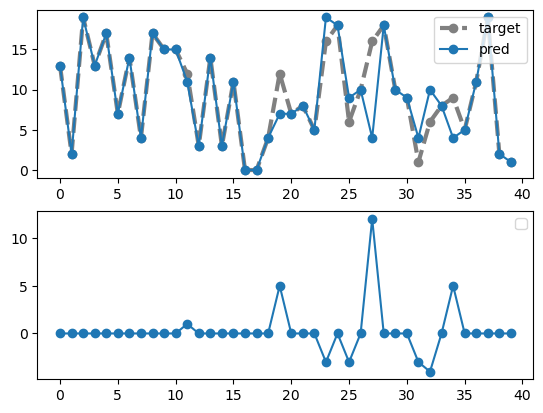

In [60]:
fig, axs = plt.subplots(2)
axs[0].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
axs[0].plot(np.array(proposed_survey), marker='o', label='pred')
axs[0].legend()

axs[1].plot(np.array(true_sequence) - np.array(proposed_survey), marker='o')
axs[1].legend()


In [69]:
evaluate_policy(model, env)

/home/hurra/.conda/envs/cosmoML/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(np.float64(4.000000014901161), np.float64(0.0))

# Use monitor

In [78]:
env = Monitor(env)

In [79]:
model = DQN(
    "MultiInputPolicy",
    env,
    verbose=1,
    learning_rate=.0001,
    target_update_interval=int(len(true_sequence)*3),
)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [80]:
model.learn(total_timesteps=20000, log_interval=4)
model.save("simpleTel-DQNv1")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10723    |
|    time_elapsed     | 0        |
|    total_timesteps  | 116      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 3        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 3.67     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4563     |
|    time_elapsed     | 0        |
|    total_timesteps  | 232      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates      

In [81]:
observation_list = []
reward_list = []
terminated_list = []
truncated_list = []
info_list = []

obs, info = env.reset()
observation_list.append(obs)
info_list.append(info)
for i in range(len(true_sequence)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action.tolist())
    observation_list.append(obs)
    reward_list.append(reward)
    terminated_list.append(terminated)
    truncated_list.append(truncated)
    info_list.append(info)
    if terminated or truncated:
        print(i)
        break

28


In [82]:
proposed_survey = [observation_list[i]['field_id'] for i in range(len(observation_list))]
print(proposed_survey)

[1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [83]:
print(true_sequence)

[1, 7, 5, 5, 0, 8, 1, 2, 4, 5, 6, 8, 4, 6, 3, 4, 7, 9, 2, 6, 2, 3, 7, 1, 3, 8, 0, 0, 9, 9]


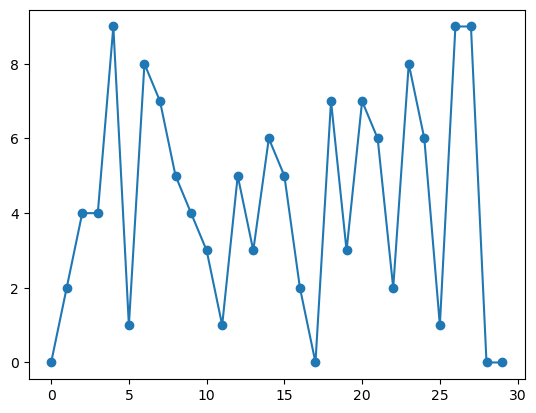

In [84]:
plt.plot(np.array(proposed_survey) - np.array(true_sequence), marker='o')